In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import math
import json
import librosa
import librosa.display
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pprint import pprint
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [ ]:
file ="/content/drive/My Drive/Dataset/genres_original/rock/rock.00052.wav"

signal, sr = librosa.load(file,sr=22050)
signal.size

661794

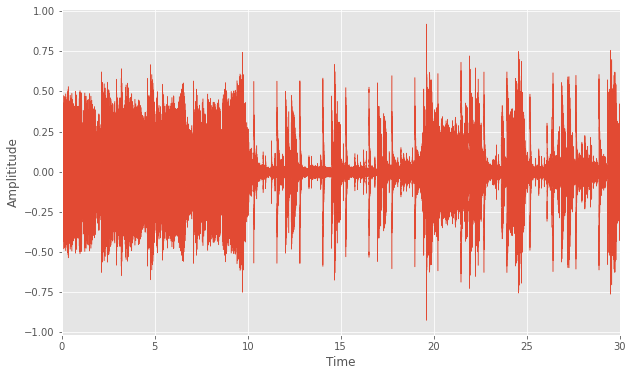

In [ ]:
plt.figure(figsize=(10,6))
librosa.display.waveplot(signal,sr=sr)
plt.xlabel('Time')
plt.ylabel('Amplititude')
plt.show()

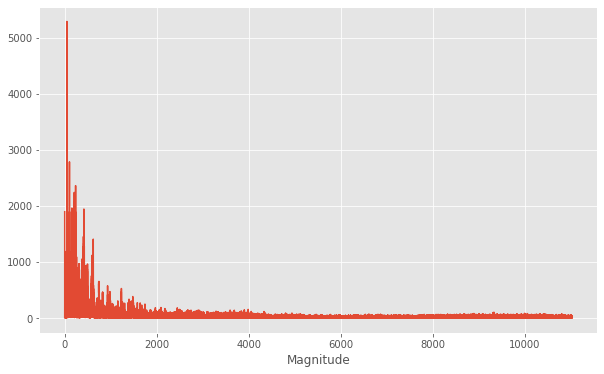

661794


In [ ]:
fft = np.fft.fft(signal)

magnitude = np.abs(fft)
frequency = np.linspace(0,sr,len(magnitude))

left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(magnitude)/2)]


plt.figure(figsize=(10,6))
plt.plot(left_frequency, left_magnitude)
plt.xlabel('Frequency')
plt.xlabel('Magnitude')
plt.show()

print(len(frequency))

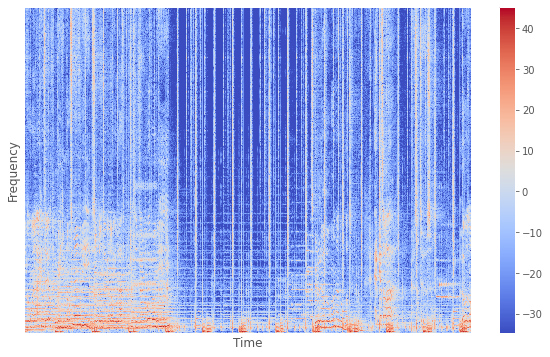

In [ ]:
n_fft = 2048 ## no of samples per fft
hop_length = 512
stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)

spectogram = np.abs(stft)

log_spectogram = librosa.amplitude_to_db(spectogram)

#plotting 
plt.figure(figsize=(10,6))
librosa.display.specshow(log_spectogram, sr=sr, hop_length=hop_length)

plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()

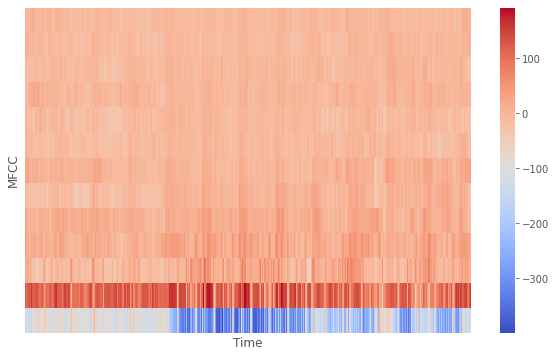

In [ ]:
MFFCs = librosa.feature.mfcc(signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

#plotting 
plt.figure(figsize=(10,6))
librosa.display.specshow(MFFCs, sr=sr, hop_length=hop_length)

plt.xlabel('Time')
plt.ylabel('MFCC')
plt.colorbar()
plt.show()

In [ ]:
DATASET_PATH = "/content/drive/My Drive/Dataset/genres_original/"
JSON_PATH = "data.json"
SAMPLE_RATE = 22050
DURATION = 30 #measured by seconds 
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
def save_mfcc(dataset_path,json_path, n_mfcc=13,n_fft=2048,hop_length=512, num_segments=5):
  # dictionary to store data
  data = {
      "mapping" : [],
      "mfcc" : [],
      "labels" : [],
  }

  num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
  expected_n_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)

  for i, (dirpath,dirname,filenames) in (enumerate(os.walk(dataset_path))):
    # ensure we are not at the root level
    if (dirpath) is not dataset_path:
      #Save the semantic label
      dirpath_components = dirpath.split('/') # genre/blues = ["genre", "blues"]
      semantic_label = dirpath_components[-1]
      data["mapping"].append(semantic_label)
      pprint(f"Processing {semantic_label}")

      # process files for specific genre
      for f in tqdm(filenames):
        file_path = os.path.join(dirpath,f)
        signal,sr = librosa.load(file_path, sr=SAMPLE_RATE)
        
        # process segments, extracting mfcc, storing data
        for s in range(num_segments):
          start_sample = num_samples_per_segment * s  # s= 0 -> 0
          finish_sample = start_sample + num_samples_per_segment  # s =0 -> num_samples_per_segment

          mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample], 
                                      sr=sr,
                                      n_fft= n_fft,
                                      n_mfcc=n_mfcc,
                                      hop_length=hop_length
                                      )
          mfcc = mfcc.T
          #Store if expected == mfcc length
          if(len(mfcc) == expected_n_mfcc_vectors_per_segment):
            data["mfcc"].append(mfcc.tolist())
            data["labels"].append(i-1)
          
  with open(json_path, "w") as fp:
    json.dump(data,fp,indent=4)

In [ ]:
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

  1%|          | 1/99 [00:00<00:10,  9.69it/s]

'Processing classical'


  1%|          | 1/99 [00:00<00:10,  8.95it/s]

'Processing metal'


  1%|          | 1/99 [00:00<00:10,  9.19it/s]

'Processing hiphop'


  1%|          | 1/99 [00:00<00:11,  8.61it/s]

'Processing pop'


  1%|          | 1/99 [00:00<00:10,  9.58it/s]

'Processing jazz'


  0%|          | 0/99 [00:00<?, ?it/s]

'Processing reggae'


  1%|          | 1/99 [00:00<00:10,  9.34it/s]

'Processing country'


  1%|          | 1/99 [00:00<00:10,  9.18it/s]

'Processing disco'


  1%|          | 1/99 [00:00<00:10,  9.01it/s]

'Processing rock'


  1%|          | 1/99 [00:00<00:10,  9.34it/s]

'Processing blues'


100%|██████████| 99/99 [00:11<00:00,  8.77it/s]


In [ ]:
DATASET_PATH ="data.json"

In [ ]:
def load_data(dataset_path):
  with open(dataset_path, "r") as fp:
    data = json.load(fp)

    # convert lists into numpy array
    inputs = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return inputs, y
    
inputs, y = load_data(DATASET_PATH)

In [ ]:
len(data['mfcc'])

9896

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(inputs,y, test_size=0.2, stratify=y)
len(x_train), len(x_test)

(7916, 1980)

In [ ]:
input_shape = (x_train.shape[1], x_train.shape[2])

model = Sequential()

model.add(LSTM(128, input_shape=input_shape, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(LSTM(128, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 130, 128)          72704     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
history = model.fit(x_train,
                    y_train,
                    validation_data=(x_test,y_test),
                    epochs=70,
                    batch_size=32)

Epoch 1/70
248/248 [==============================] - 14s 21ms/step - loss: 2.3758 - accuracy: 0.1958 - val_loss: 2.1213 - val_accuracy: 0.3146
Epoch 2/70
248/248 [==============================] - 5s 19ms/step - loss: 2.0591 - accuracy: 0.3260 - val_loss: 1.7965 - val_accuracy: 0.4323
Epoch 3/70
248/248 [==============================] - 5s 18ms/step - loss: 1.8474 - accuracy: 0.4006 - val_loss: 1.6503 - val_accuracy: 0.4692
Epoch 4/70
248/248 [==============================] - 5s 19ms/step - loss: 1.7160 - accuracy: 0.4452 - val_loss: 1.5482 - val_accuracy: 0.5096
Epoch 5/70
248/248 [==============================] - 5s 19ms/step - loss: 1.6037 - accuracy: 0.4850 - val_loss: 1.4824 - val_accuracy: 0.5273
Epoch 6/70
248/248 [==============================] - 5s 19ms/step - loss: 1.5345 - accuracy: 0.5056 - val_loss: 1.4144 - val_accuracy: 0.5591
Epoch 7/70
248/248 [==============================] - 5s 19ms/step - loss: 1.4570 - accuracy: 0.5433 - val_loss: 1.3485 - val_accuracy: 0.583

In [ ]:
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

62/62 [==============================] - 1s 8ms/step - loss: 0.9873 - accuracy: 0.8116
Test Accuracy: 81.16161823272705


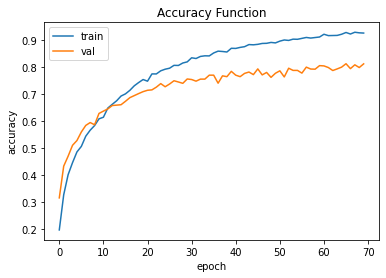

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('Accuracy Function')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])
plt.show()

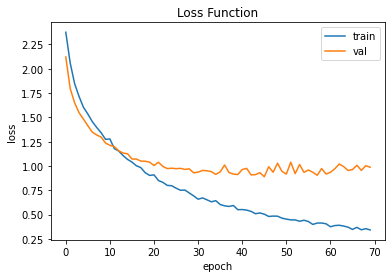

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss)
plt.plot(val_loss)
plt.title('Loss Function')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

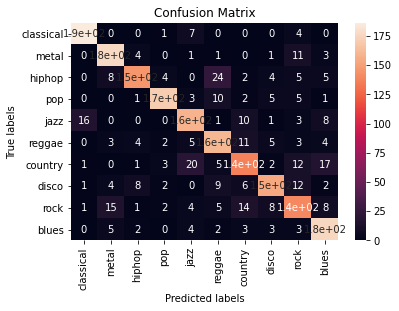

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

label_list = ['classical', 'metal', 'hiphop', 'pop', 'jazz', 'reggae', 'country', 'disco', 'rock', 'blues']

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
# y_test2 = np.argmax(y_test,axis=1)

cm = confusion_matrix(y_test,pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(label_list,rotation=90); ax.yaxis.set_ticklabels(label_list,rotation=0);